# Mask R-CNN Training and Inference
This notebook is part of the _Automated plant stage labelling of herbarium samples in the family *Brassicaceae*_ made at [Propulsion Academy Zurich](https://propulsion.academy/?gclid=Cj0KCQiAwf39BRCCARIsALXWETyIhnHT7bA3VYXXOC415brejc6qYXnX7kEpqJmmJ5d5kAcYgoiLhI4aAmPxEALw_wcB) in collaboration with [ETH Library](https://library.ethz.ch/en/).

In this notebook we use a ported version of Matterport's implementation of Mask R-CNN to train on a custom dataset, then use the trained weights to run inference on new images.

**IMPORTANT** : To make the model work please download:  
1. Mask_RCNN model files from [the AkTwelve's repo](https://github.com/akTwelve/Mask_RCNN) and add it to the src folder with the name "Mask_RCNN"  
2. Model weights from the following address: [model weights](https://drive.google.com/drive/folders/1HNs_EUyxMg8ThCRuseuJPSDYXR50GDNR?usp=sharing) and place it in the src folder with the name "model_weights"  
3. OPTIONAL annotated dataset from the following links: [train](https://drive.google.com/drive/folders/13Nph-NoTZwQFj-WOxwXtG61Wcf6fS9LR?usp=sharing), [test](https://drive.google.com/drive/folders/10-WqciDfjVAf5Qg6cJlHeigzvAWWDiQl?usp=sharing)

## Imports

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
sys.path.append("../src")
sys.path.append("../src/Mask_RCNN")

ROOT_DIR =  '../src/Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'
 
import herbaria as hb
try:
    from mrcnn.config import Config
    import mrcnn.utils as utils
    from mrcnn import visualize
    import mrcnn.model as modellib
except ModuleNotFoundError:
    assert "Mask_RCNN modules not found. Did you download the Modules from https://github.com/akTwelve/Mask_RCNN to the src folder?"

## Data path and settings

You can set in the cell below all the needed paths to data and model files

In [3]:
# directory for input images, annotations and output images 
PROJECT_DIR = os.path.join("..", "data")
assert os.path.exists(PROJECT_DIR), 'PROJECT_DIR does not exist. Did you forget to read the instructions above? ;)'

# train dataset
TRAIN_DIR = os.path.join(PROJECT_DIR, "train")
TRAIN_ANNOTATIONS_FILE = os.path.join(TRAIN_DIR, "train.json")

# test dataset
TEST_DIR = os.path.join(PROJECT_DIR, "train")
TEST_ANNOTATIONS_FILE = os.path.join(TEST_DIR, "train.json")

OUTPUT_DIR = os.path.join(PROJECT_DIR,"OUTPUT_images")

# Directory to save logs and trained model
MODEL_DIR = os.path.join("..", "src", "model_weights")

## Configuration
### Define configurations for training

Below are the configs to create the model and the dataset. They are based on the main class of the Mask_RCNN `utils.Config()` and are present in the herbaria.py module. Here we show the full config. Then we actually import it from herbaria.py


In [4]:
class HerbariaConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "M_image_augm"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2   # background + 2 [ 'flower', fruit]

    # All of our training images are 1024x1024
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 4

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 1
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    LEARNING_RATE=0.01
    

In [5]:
config = hb.HerbariaConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

# Define the dataset

As for the `HerbariaConfig` class, this class holds the specification for DATASET creation. The class is shown in the cell below, than actually imported from `herbaria.py`

In [6]:
class HerbariaDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

### Create the Training and Validation Datasets
This allows to use the dataset class to load a train and validation dataset (by default in the './data' folder). 

To download a sample train and test dataset see the  `README` or follow the link at the top of this notebook

In [7]:
# Set the data sources for images and  annotations /ground truth 
# train dataset
dataset_train = hb.HerbariaDataset()
dataset = HerbariaDataset()
dataset.load_data(TRAIN_ANNOTATIONS_FILE, TRAIN_DIR)
dataset.prepare()

# test dataset
dataset_val = hb.HerbariaDataset()
dataset_val.load_data(TEST_ANNOTATIONS_FILE, TEST_DIR)
dataset_val.prepare()

### Display a few images from the training dataset

In [18]:
def display_top_masks_layered(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

2


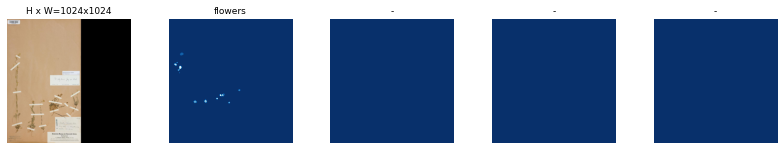

1


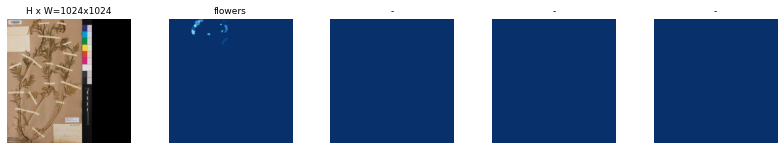

5


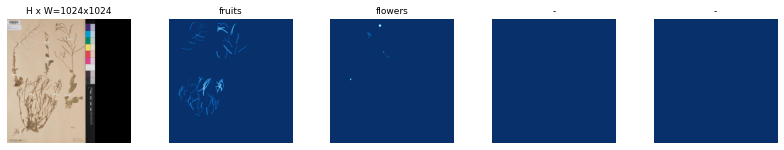

0


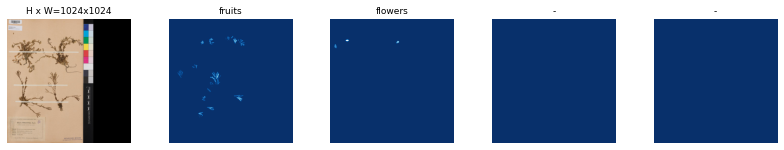

In [19]:
dataset = dataset
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    
    print(image_id)
    
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train

A predefined way to create the model wqith pre-trained way is available in herbaria.py through the `hb.load_trained_model()` function. Here below we generate a new model directly from the mask_rcnn module

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [12]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Image augmentations and callbacks

The following are the image augmentations and callbacks used in for our best performing model. 
Other image augmentations can be set up using the [imgaug library](https://imgaug.readthedocs.io/en/latest/)

#### NOTE: 
There are several variations of the training routine that were not implemented because they would require deeper modification of the Mask_RCNN modules, and thus would break compatibility with the original repo:
- **optimizers**: the default optimizer is SDG and this is hard coded within the `train` function of the mrcnn module
- **learning rate schedulers/modifiers**: any learning rate modifier appears to break the trainign routine resulting in an error. Deeper modifications of the `train`function could solve the problem 

In [23]:
# set img augmentations and callbacks
from keras.callbacks import EarlyStopping
import imgaug

CALLBACKS=[
    EarlyStopping(monitor = 'val_loss', patience=10, restore_best_weights=True),  
          ]

my_aug = imgaug.augmenters.SomeOf(0.8, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Flipud(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0)),
                    imgaug.augmenters.Multiply((0.5, 1.5), per_channel=0.5),
                    imgaug.augmenters.AdditiveGaussianNoise(scale=(0, 0.2*255)),
                    imgaug.augmenters.AddElementwise((-40, 40))
                                        ])

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.01

Checkpoint Path: ../src/model_weights/m_image_augm20201126T0941/mask_rcnn_m_image_augm_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_decon

Process Keras_worker_ForkPoolWorker-176:
Process Keras_worker_ForkPoolWorker-174:
Process Keras_worker_ForkPoolWorker-173:
Process Keras_worker_ForkPoolWorker-177:
Process Keras_worker_ForkPoolWorker-175:
Traceback (most recent call last):
  File "/home/matt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [8]:
print('training finished at: ', time.time())

training finished at:  1606380255.699741


In [13]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="3+")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../src/model_weights/m_image_augm20201126T0944/mask_rcnn_m_image_augm_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

KeyboardInterrupt: 

# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [14]:
class InferenceConfig(hb.HerbariaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    DETECTION_MIN_CONFIDENCE = 0.5
    
inference_config = InferenceConfig()

In [15]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [17]:
# Get path to saved weights
# Either set a specific path or find last trained weights

model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
# model_path = ".."

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

FileNotFoundError: [Errno 2] Could not find weight files in ../src/model_weights/m_image_augm20201126T0944

# Run Inference

Run model.detect() on real images.

In [ ]:
import skimage
real_test_dir = fldr_path_test_images
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))